In [45]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import timeit
from sklearn import decomposition


In [46]:
path_to_file = r'/Users/gulsumkapanoglu/Desktop/P4/'

In [47]:
energy = pd.read_csv(path_to_file + 'energy-cleaned.csv')

In [48]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  1085 non-null   int64  
 1   DataYear                       1085 non-null   int64  
 2   BuildingType                   1085 non-null   object 
 3   PrimaryPropertyType            1085 non-null   object 
 4   ZipCode                        1079 non-null   float64
 5   TaxParcelIdentificationNumber  1085 non-null   object 
 6   CouncilDistrictCode            1085 non-null   int64  
 7   Neighborhood                   1085 non-null   object 
 8   NumberofBuildings              1085 non-null   float64
 9   NumberofFloors                 1085 non-null   int64  
 10  PropertyGFATotal               1085 non-null   int64  
 11  ListOfAllPropertyUseTypes      1085 non-null   object 
 12  LargestPropertyUseType         1085 non-null   o

In [49]:
energy = energy.drop(['TaxParcelIdentificationNumber','ListOfAllPropertyUseTypes', 'DataYear','SourceEUIWN(kBtu/sf)','SiteEUIWN(kBtu/sf)'], axis=1)

In [50]:
def reg_met(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r_score = r2_score(y_test, y_pred, multioutput="variance_weighted")
    print("MAE: ",mae.round(5))
    print("MSE: ", mse.round(5))
    print("RMSE: ", rmse)
    print("MAPE: ", mape.round(5))
    print("R²: ", r_score.round(5))

In [51]:
energy[(energy.GFAPerBuilding == np.inf) | (energy.GFAPerFloor == np.inf)].head()

,OSEBuildingID,BuildingType,PrimaryPropertyType,ZipCode,CouncilDistrictCode,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,...,GHGEmissionsIntensity,Âgebâtiment,out_clas,consumption_rate_Electricity,consumption_rate_Gas,consumption_rate_Steam,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor
57,89,NonResidential,Medical Office,98122.0,3,EAST,0.0,3,179014,Medical Office,...,2.41,51,Low,High Usage,High Usage,Low Usage,1.00000,0.00000,inf,59671.333
144,267,NonResidential,Hotel,98101.0,7,DOWNTOWN,1.0,0,934292,Hotel,...,1.75,17,Low,High Usage,High Usage,Low Usage,1.00000,0.00000,934292.0,inf
172,322,NonResidential,Large Office,98121.0,7,DOWNTOWN,0.0,3,100734,Office,...,0.68,48,Low,High Usage,Low Usage,Low Usage,0.73464,0.26536,inf,33578.000
208,366,NonResidential,Small- and Mid-Sized Office,98105.0,4,NORTHEAST,0.0,5,99005,Office,...,1.20,55,Low,High Usage,High Usage,Low Usage,1.00000,0.00000,inf,19801.000
228,391,NonResidential,Mixed Use Property,98108.0,2,GREATER DUWAMISH,0.0,1,88400,Non-Refrigerated Warehouse,...,1.31,46,Low,High Usage,High Usage,Low Usage,1.00000,0.00000,inf,88400.000


In [52]:
energy['GFAPerBuilding'] = np.where(((energy.GFAPerBuilding == np.inf) & (energy.NumberofBuildings == 0)),0, energy.GFAPerBuilding)
energy['GFAPerFloor'] = np.where(((energy.GFAPerFloor == np.inf) & (energy.NumberofFloors == 0)),0, energy.GFAPerFloor)

In [53]:
numerical_features = energy.select_dtypes(include=['int64','float64'])
categorical_features = energy.select_dtypes(exclude=['int64','float64'])

In [54]:
categorical_features.nunique()

BuildingType                     4
PrimaryPropertyType             20
Neighborhood                    13
LargestPropertyUseType          50
ComplianceStatus                 2
out_clas                         1
consumption_rate_Electricity     2
consumption_rate_Gas             2
consumption_rate_Steam           2
dtype: int64

In [55]:
categorical_features = categorical_features.drop(['ComplianceStatus','out_clas'], axis=1)

In [56]:
list(numerical_features.columns)

['OSEBuildingID',
 'ZipCode',
 'CouncilDistrictCode',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'ENERGYSTARScore',
 'SiteEnergyUseWN(kBtu)',
 'Electricity(kWh)',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity',
 'Âgebâtiment',
 'GFABuildingRate',
 'GFAParkingRate',
 'GFAPerBuilding',
 'GFAPerFloor']

In [57]:
energystar_score = numerical_features['ENERGYSTARScore']
numerical_features = numerical_features.drop(['ENERGYSTARScore','OSEBuildingID','CouncilDistrictCode','ZipCode','Electricity(kWh)','GHGEmissionsIntensity',], axis=1)

In [58]:
data_filter = pd.concat([categorical_features, numerical_features], axis=1)

In [59]:
data_filter.head()

,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType,consumption_rate_Electricity,consumption_rate_Gas,consumption_rate_Steam,NumberofBuildings,NumberofFloors,PropertyGFATotal,SiteEnergyUseWN(kBtu),TotalGHGEmissions,Âgebâtiment,GFABuildingRate,GFAParkingRate,GFAPerBuilding,GFAPerFloor
0,NonResidential,Hotel,DOWNTOWN,Hotel,High Usage,High Usage,High Usage,1.0,12,88434,7456910.0,249.98,89,1.00000,0.00000,88434.0,7369.500
1,NonResidential,Hotel,DOWNTOWN,Hotel,High Usage,High Usage,Low Usage,1.0,11,103566,8664479.0,295.86,20,0.85455,0.14545,103566.0,9415.091
2,NonResidential,Hotel,DOWNTOWN,Hotel,High Usage,High Usage,High Usage,1.0,41,956110,73937112.0,2089.28,47,0.79425,0.20575,956110.0,23319.756
3,NonResidential,Hotel,DOWNTOWN,Hotel,High Usage,High Usage,High Usage,1.0,10,61320,6946800.5,286.43,90,1.00000,0.00000,61320.0,6132.000
4,NonResidential,Hotel,DOWNTOWN,Hotel,High Usage,High Usage,Low Usage,1.0,18,175580,14656503.0,505.01,36,0.64688,0.35312,175580.0,9754.444


In [60]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer

target_features = ['BuildingType','PrimaryPropertyType','Neighborhood','LargestPropertyUseType',
                   'consumption_rate_Electricity','consumption_rate_Gas','consumption_rate_Steam']
target_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

numeric_features = ['NumberofBuildings','NumberofFloors',
                    'PropertyGFATotal','Âgebâtiment','GFABuildingRate','GFAParkingRate',
                    'GFAPerBuilding','GFAPerFloor']
numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ('target', target_transformer, target_features),
    ('numeric', numeric_transformer, numeric_features)
])

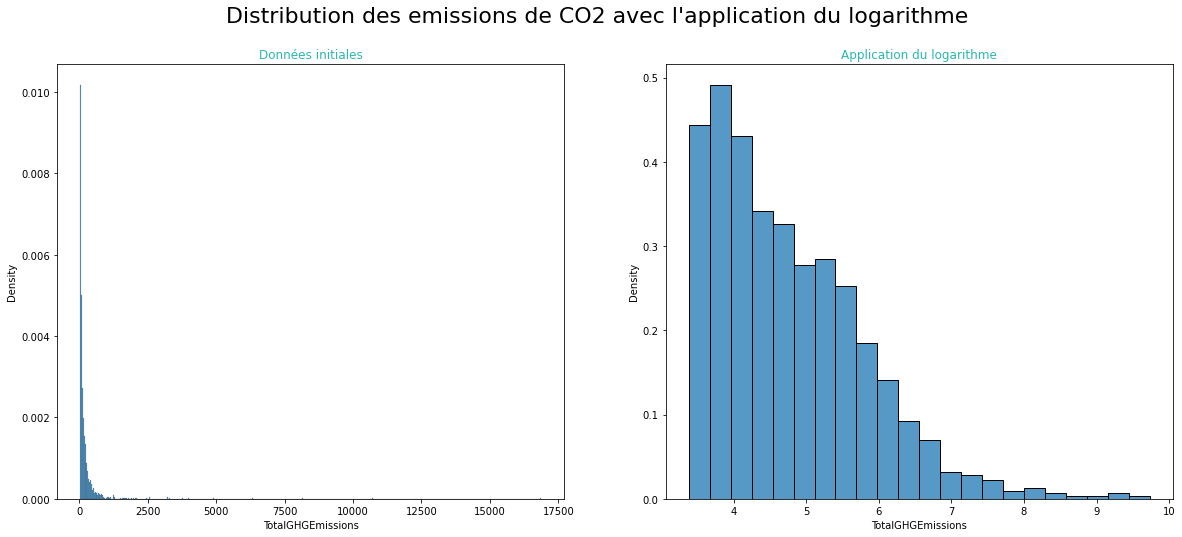

In [61]:
from sklearn.preprocessing import FunctionTransformer
Y = data_filter[["TotalGHGEmissions","SiteEnergyUseWN(kBtu)"]]
logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)
Y_log = logtransformer.transform(Y)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=Y, x='TotalGHGEmissions', stat="density", ax=axes[0])
axes[0].set_title("Données initiales", color='#2cb7b0')
sns.histplot(data=Y_log, x='TotalGHGEmissions', stat="density", ax=axes[1])
axes[1].set_title("Application du logarithme", color='#2cb7b0')
plt.suptitle("Distribution des emissions de CO2 avec l'application du logarithme",fontsize=22)
plt.show()

In [62]:
data_filter["SiteEnergyUseWN(kBtu)_log"] = np.log(data_filter["SiteEnergyUseWN(kBtu)"])
data_filter["TotalGHGEmissions_log"] = np.log(data_filter["TotalGHGEmissions"])

## Les Modeles De Prediction de emisson de CO2

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [64]:
from sklearn.model_selection import train_test_split

X = data_filter.drop(['TotalGHGEmissions','SiteEnergyUseWN(kBtu)',"SiteEnergyUseWN(kBtu)_log","TotalGHGEmissions_log"], axis=1)
Y = data_filter[["TotalGHGEmissions_log"]]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))


Entrainement: 813 lignes,
Test: 272 lignes.



## Modèle Baseline 

In [65]:
# transformation des variables
X_train = preprocessor.fit_transform(X_train)

In [66]:
from sklearn.dummy import DummyRegressor

dummy_reg = DummyRegressor(strategy="median")
dummy_reg.fit(X_train, Y_train)

DummyRegressor(strategy='median')

In [67]:
# Prédiction dummy regressor
# Evaluation du modèle
X_test = preprocessor.transform(X_test)
Y_pred= dummy_reg.predict(X_test)
reg_met(np.array(Y_test), Y_pred)

MAE:  0.84583
MSE:  1.22629
RMSE:  1.1073808685963469
MAPE:  0.17162
R²:  -0.02068


In [68]:
# examiner différents modèles de régression
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso,Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import AdaBoostRegressor,RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

dummy_reg = DummyRegressor(strategy="median")
lasso = Lasso(random_state=42)
ridge = Ridge(random_state=42)
dt_reg =  DecisionTreeRegressor(random_state=42)
svm_reg = SVR()
ridge_kernel = KernelRidge()
adaboost = AdaBoostRegressor(random_state=42)
rdmforest = RandomForestRegressor(random_state=42)
gdboost = GradientBoostingRegressor(random_state=42)
neigh = KNeighborsRegressor(n_neighbors=3)

In [69]:
#Les modèles sans paramètre spécifique
# MAE, MSE, RMSE, R²
model = [dummy_reg, lasso, ridge,  dt_reg, svm_reg, ridge_kernel, adaboost, rdmforest, gdboost,  neigh]
dict_model = {}

for model in model:
    model.fit(X_train, Y_train)
    start_time = timeit.default_timer()
    Y_pred = model.predict(X_test)
    time = timeit.default_timer() - start_time
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(Y_test, Y_pred, multioutput="variance_weighted").round(3)
    dict_model[model] = (mae.round(3), mse.round(3), rmse.round(3), r_score, time)

results = pd.DataFrame(dict_model, index=["MAE", "MSE", "RMSE", "R²","time"])
results.columns = ["Dummy Regressor", "Lasso", "Ridge", "DecisionTree", "SVM", "Ridge Kernel",
                      "AdaBoost","Random Forest", "GradientBoosting", "KNN"]

results

,Dummy Regressor,Lasso,Ridge,DecisionTree,SVM,Ridge Kernel,AdaBoost,Random Forest,GradientBoosting,KNN
MAE,0.846000,0.873000,0.576000,0.690000,0.530000,0.575000,0.728000,0.547000,0.544000,0.609000
MSE,1.226000,1.204000,0.679000,0.884000,0.505000,0.673000,0.739000,0.511000,0.497000,0.625000
RMSE,1.107000,1.097000,0.824000,0.940000,0.711000,0.821000,0.859000,0.715000,0.705000,0.791000
R²,-0.021000,-0.002000,0.435000,0.264000,0.580000,0.440000,0.385000,0.574000,0.586000,0.480000
time,0.000072,0.000314,0.000396,0.000366,0.062149,0.002362,0.006789,0.013359,0.000697,0.004309


In [70]:
results_t=results.transpose()

In [71]:
results_t.reset_index(inplace=True)

In [72]:
results_t.rename(columns={"index": "Nom de Model"},inplace=True)

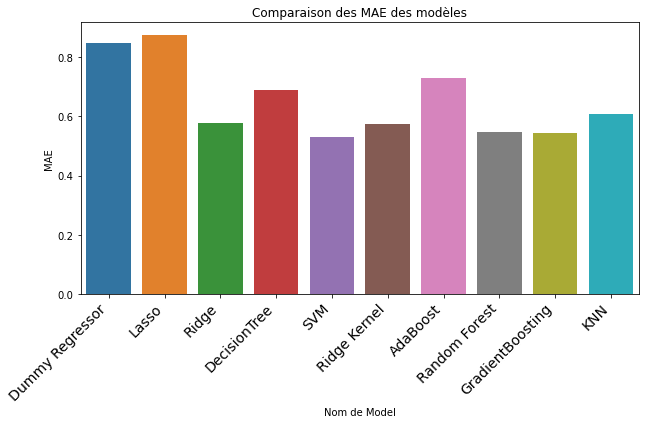

In [73]:
plt.figure(figsize=(10,5))
plt.title('Comparaison des MAE des modèles')
ax = sns.barplot(x = results_t['Nom de Model'], y = results_t['MAE'])
ax.set_xticklabels(labels = results_t['Nom de Model'], rotation=45, horizontalalignment='right',size=14)
plt.show()

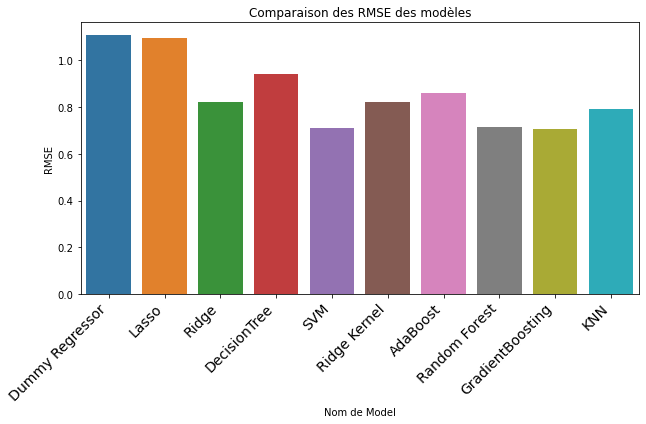

In [75]:
plt.figure(figsize=(10,5))
plt.title('Comparaison des RMSE des modèles')
ax = sns.barplot(x = results_t['Nom de Model'], y = results_t['RMSE'])
ax.set_xticklabels(labels = results_t['Nom de Model'], rotation=45, horizontalalignment='right',size=14)
plt.show()

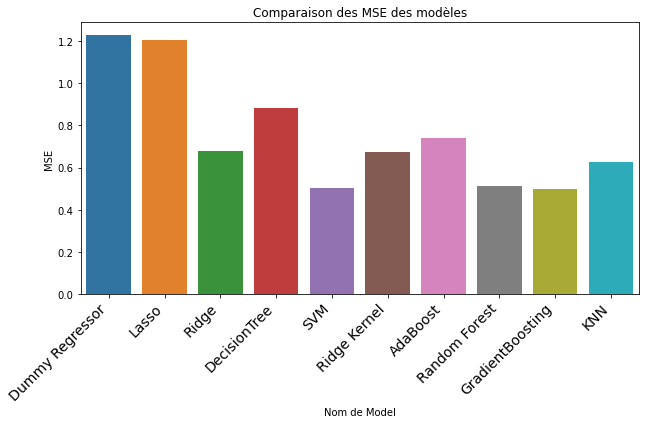

In [76]:
plt.figure(figsize=(10,5))
plt.title('Comparaison des MSE des modèles')
ax = sns.barplot(x = results_t['Nom de Model'], y = results_t['MSE'])
ax.set_xticklabels(labels = results_t['Nom de Model'], rotation=45, horizontalalignment='right',size=14)
plt.show()

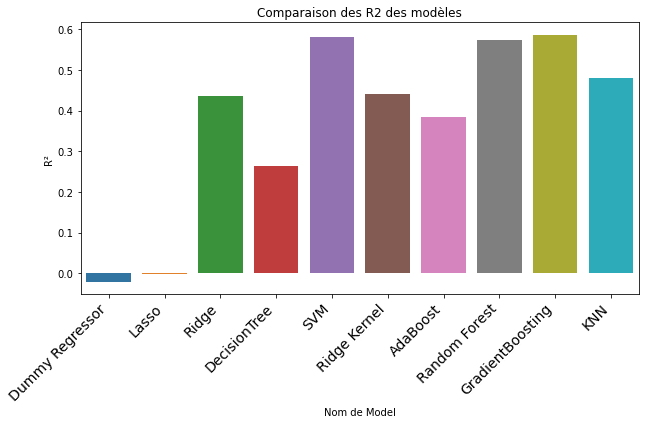

In [77]:
plt.figure(figsize=(10,5))
plt.title('Comparaison des R2 des modèles')
ax = sns.barplot(x = results_t['Nom de Model'], y = results_t['R²'])
ax.set_xticklabels(labels = results_t['Nom de Model'], rotation=45, horizontalalignment='right',size=14)
plt.show()

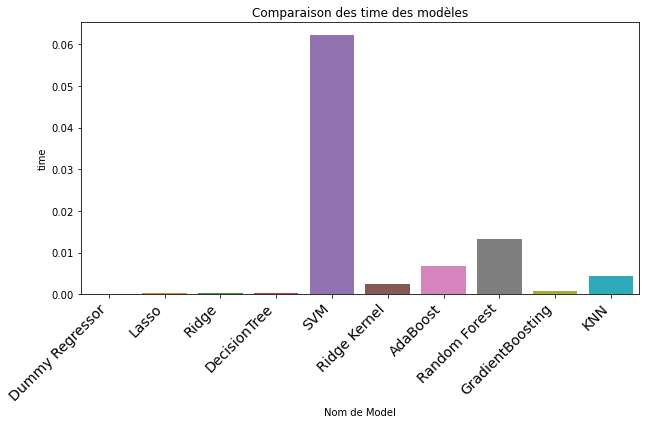

In [78]:
plt.figure(figsize=(10,5))
plt.title('Comparaison des time des modèles')
ax = sns.barplot(x = results_t['Nom de Model'], y = results_t['time'])
ax.set_xticklabels(labels = results_t['Nom de Model'], rotation=45, horizontalalignment='right',size=14)
plt.show()

L'algorithme qui donne le meilleur résultat en termes de score R2 est GradientBoosting. Ensuite, même si GradientBoosting Regressor est le meilleur choix en regardant la variable execution time, nous examinerons également l'algorithme de Random Forest, qui vient en deuxième position. Nous choisirons le meilleur algorithme en optimisant les paramètres.

Choix du modèle : GradientBoostingRegressor et Random Forest

## Recherche des  meilleurs hyperparamètres et des models

### GradientBoostingRegressor

In [79]:
from scipy.stats import loguniform
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

gb_params = {"n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
             "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
             "learning_rate" : [0.001, 0.01, 0.1, 0.2, 0,3],
             "max_depth": [6, 10, 15, 20],
             }

gdboost = GradientBoostingRegressor(random_state=42)

gb_cv_model = GridSearchCV(gdboost,
                           gb_params,
                           cv=5,
                           n_jobs = 2,
                          scoring="neg_mean_squared_error")

gb_cv_model.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=2,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.2, 0, 3],
                         'max_depth': [6, 10, 15, 20],
                         'max_leaf_nodes': [2, 5, 10, 20, 50, 100],
                         'n_estimators': [1, 2, 5, 10, 20, 50, 100, 200, 500]},
             scoring='neg_mean_squared_error')

In [80]:
gb_cv_model.best_params_

{'learning_rate': 0.2,
 'max_depth': 6,
 'max_leaf_nodes': 2,
 'n_estimators': 200}

In [81]:
gb_cv_model_tuned =  GradientBoostingRegressor(learning_rate = 0.2, 
                                               max_depth = 6, 
                                               max_leaf_nodes = 5,
                                               n_estimators = 5)

In [82]:
gb_cv_model_tuned.fit(X_train, Y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=6, max_leaf_nodes=5,
                          n_estimators=5)

In [83]:
YpredGradientBoostingRegressor = gb_cv_model_tuned.predict(X_test)

In [84]:
start_time = timeit.default_timer()
YpredGradientBoostingRegressor = gb_cv_model_tuned.predict(X_test)
elapsedGradientBoostingRegressor= timeit.default_timer() - start_time
meanErrorGradientBoostingRegressor = mean_absolute_error(Y_test, YpredGradientBoostingRegressor).round(3)
medianErrorGradientBoostingRegressor= mean_squared_error(Y_test, YpredGradientBoostingRegressor).round(3)
rmseGradientBoostingRegressor = np.sqrt(medianErrorGradientBoostingRegressor).round(3)
r2score = r2_score(Y_test,YpredGradientBoostingRegressor).round(3)

print("MAE GradientBoostingRegressor: {}".format(meanErrorGradientBoostingRegressor))
print("MSE GradientBoostingRegressor: {}".format(medianErrorGradientBoostingRegressor))
print("RMSE GradientBoostingRegressor: {}".format(rmseGradientBoostingRegressor))
print("R2 SCORE GradientBoostingRegressor : {}".format(r2score))
print("time GradientBoostingRegressor : {}".format(elapsedGradientBoostingRegressor))

MAE GradientBoostingRegressor: 0.718
MSE GradientBoostingRegressor: 0.784
RMSE GradientBoostingRegressor: 0.885
R2 SCORE GradientBoostingRegressor : 0.347
time GradientBoostingRegressor : 0.0027648640000279556


### RandomForest Regressor

In [86]:
from scipy.stats import loguniform
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf_params = {'max_features' : [3,5,10,15],
             'max_depth': [5, 15, 25, 50],
             'n_estimators': [100,200,500,1000,2000],
            }

rdmforest = RandomForestRegressor(random_state=42)

rf_cv_model = GridSearchCV(rdmforest,
                           rf_params,
                           cv=5,
                           n_jobs = 2,
                          scoring="neg_mean_squared_error")

rf_cv_model.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=2,
             param_grid={'max_depth': [5, 15, 25, 50],
                         'max_features': [3, 5, 10, 15],
                         'n_estimators': [100, 200, 500, 1000, 2000]},
             scoring='neg_mean_squared_error')

In [87]:
rf_cv_model.best_params_

{'max_depth': 15, 'max_features': 15, 'n_estimators': 2000}

In [88]:
rdmforest_tuned =  RandomForestRegressor(max_depth= 15, 
                                         max_features= 15, 
                                         n_estimators= 2000)

In [89]:
rdmforest_tuned.fit(X_train, Y_train)

RandomForestRegressor(max_depth=15, max_features=15, n_estimators=2000)

In [90]:
YpredRandomForestRegressor = rdmforest_tuned.predict(X_test)

In [91]:
start_time = timeit.default_timer()
YpredRandomForestRegressor = rdmforest_tuned.predict(X_test)
elapsedRandomForestRegressor= timeit.default_timer() - start_time
meanErrorRandomForestRegressor = mean_absolute_error(Y_test, YpredRandomForestRegressor).round(3)
medianErrorRandomForestRegressor = mean_squared_error(Y_test, YpredRandomForestRegressor).round(3)
rmseRandomForestRegressor = np.sqrt(medianErrorRandomForestRegressor).round(3)
r2score = r2_score(Y_test,YpredRandomForestRegressor).round(3)

print("MAE RandomForestRegressor: {}".format(meanErrorRandomForestRegressor))
print("MSE RandomForestRegressor: {}".format(medianErrorRandomForestRegressor))
print("RMSE RandomForestRegressor: {}".format(rmseRandomForestRegressor))
print("R2 SCORE RandomForestRegressor est: {}".format(r2score))
print("time RandomForestRegressor est: {}".format(elapsedRandomForestRegressor))

MAE RandomForestRegressor: 0.548
MSE RandomForestRegressor: 0.504
RMSE RandomForestRegressor: 0.71
R2 SCORE RandomForestRegressor est: 0.58
time RandomForestRegressor est: 0.23336673299991162


In [92]:
model = [gb_cv_model_tuned, rdmforest_tuned]
dict_results = {}

for model in model:
    model.fit(X_train, Y_train)
    start_time = timeit.default_timer()
    Y_pred = model.predict(X_test)
    time = timeit.default_timer() - start_time
    mae = mean_absolute_error(Y_test, Y_pred)
    mse = mean_squared_error(Y_test, Y_pred)
    rmse = np.sqrt(mse)
    r_score = r2_score(Y_test, Y_pred, multioutput="variance_weighted").round(3)
    dict_results[model] = (mae.round(3), mse.round(3), rmse.round(3), r_score, time)

results_gb_et_rf = pd.DataFrame(dict_results, index=["MAE", "MSE", "RMSE", "R²","time"])
results_gb_et_rf.columns = ["GradientBoosting", "RandomForest"]

results_gb_et_rf

,GradientBoosting,RandomForest
MAE,0.718000,0.547000
MSE,0.784000,0.500000
RMSE,0.886000,0.707000
R²,0.347000,0.584000
time,0.000566,0.220409


In [93]:
results_gb_et_rf_t=results_gb_et_rf.transpose()

In [94]:
results_gb_et_rf_t.reset_index(inplace=True)

In [95]:
results_gb_et_rf_t.rename(columns={"index": "Nom de Model"},inplace=True)

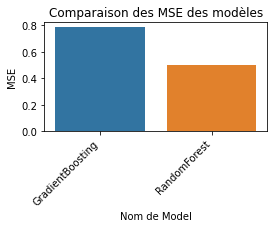

In [96]:
plt.figure(figsize=(4,2))
plt.title('Comparaison des MSE des modèles')
ax = sns.barplot(x = results_gb_et_rf_t['Nom de Model'], y = results_gb_et_rf_t['MSE'])
ax.set_xticklabels(labels = results_gb_et_rf_t['Nom de Model'], rotation=45, horizontalalignment='right',size=10)
plt.show()

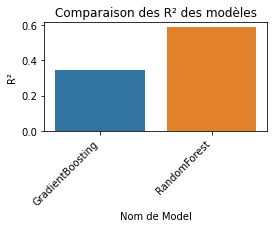

In [97]:
plt.figure(figsize=(4,2))
plt.title('Comparaison des R² des modèles')
ax = sns.barplot(x = results_gb_et_rf_t['Nom de Model'], y = results_gb_et_rf_t['R²'])
ax.set_xticklabels(labels = results_gb_et_rf_t['Nom de Model'], rotation=45, horizontalalignment='right',size=10)
plt.show()

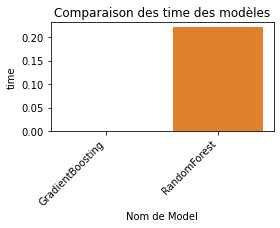

In [98]:
plt.figure(figsize=(4,2))
plt.title('Comparaison des time des modèles')
ax = sns.barplot(x = results_gb_et_rf_t['Nom de Model'], y = results_gb_et_rf_t['time'])
ax.set_xticklabels(labels = results_gb_et_rf_t['Nom de Model'], rotation=45, horizontalalignment='right',size=10)
plt.show()

### Model Selectionne

In [99]:
model_selectionne=GradientBoostingRegressor(learning_rate = 0.2, 
                                               max_depth = 6, 
                                               max_leaf_nodes = 5,
                                               n_estimators = 5)


In [100]:
model_selectionne.fit(X_train,Y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=6, max_leaf_nodes=5,
                          n_estimators=5)

In [101]:
Y_pred= model_selectionne.predict(X_test)
reg_met(np.array(Y_test), Y_pred)

MAE:  0.71785
MSE:  0.78441
RMSE:  0.885669689015457
MAPE:  0.15345
R²:  0.34711


Text(0, 0.5, 'Les valeurs estimées')

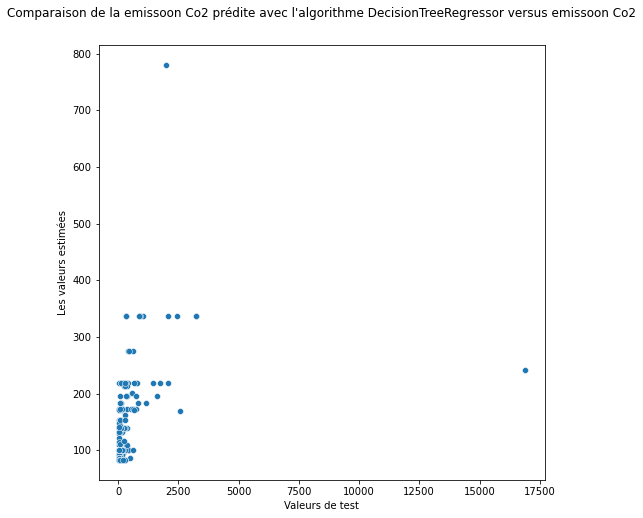

In [117]:
plt.figure(figsize=(8,8))

sns.scatterplot(np.exp(Y_test["TotalGHGEmissions_log"]), np.exp(Y_pred))
plt.title('Comparaison de la emissoon Co2 prédite avec l\'algorithme DecisionTreeRegressor versus emissoon Co2', y=1.05)
plt.xlabel('Valeurs de test')
plt.ylabel('Les valeurs estimées')

### Feature_importance

In [105]:
feature_importance = model_selectionne.feature_importances_

In [106]:
fi = preprocessor.get_params()['transformers']
feature_names = []
for name,transformer,features in fi:
    try:
        Var = preprocessor.named_transformers_[name].get_feature_names().tolist()
    except AttributeError:
        Var = features
    feature_names = feature_names + Var

feature_names

['x0_Campus',
 'x0_NonResidential',
 'x0_Nonresidential COS',
 'x0_SPS-District K-12',
 'x1_Distribution Center',
 'x1_Hospital',
 'x1_Hotel',
 'x1_K-12 School',
 'x1_Laboratory',
 'x1_Large Office',
 'x1_Medical Office',
 'x1_Mixed Use Property',
 'x1_Other',
 'x1_Refrigerated Warehouse',
 'x1_Residence Hall',
 'x1_Restaurant',
 'x1_Retail Store',
 'x1_Self-Storage Facility',
 'x1_Senior Care Community',
 'x1_Small- and Mid-Sized Office',
 'x1_Supermarket / Grocery Store',
 'x1_University',
 'x1_Warehouse',
 'x1_Worship Facility',
 'x2_BALLARD',
 'x2_CENTRAL',
 'x2_DELRIDGE',
 'x2_DOWNTOWN',
 'x2_EAST',
 'x2_GREATER DUWAMISH',
 'x2_LAKE UNION',
 'x2_MAGNOLIA / QUEEN ANNE',
 'x2_NORTH',
 'x2_NORTHEAST',
 'x2_NORTHWEST',
 'x2_SOUTHEAST',
 'x2_SOUTHWEST',
 'x3_Adult Education',
 'x3_Automobile Dealership',
 'x3_College/University',
 'x3_Courthouse',
 'x3_Data Center',
 'x3_Distribution Center',
 'x3_Financial Office',
 'x3_Fire Station',
 'x3_Fitness Center/Health Club/Gym',
 'x3_Hospita

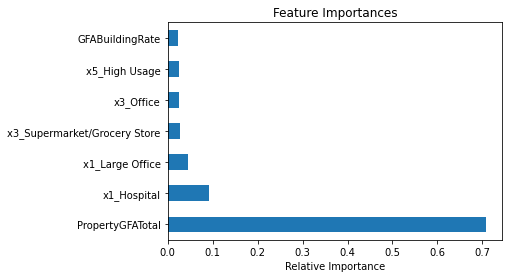

In [107]:
features_importances = pd.Series(feature_importance,index=feature_names)
features_importances.nlargest(7).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.show()

### L'effet du score ENERGY STAR

In [108]:
#Ajout de la variable à nos variables X
X['energystar_score'] = energystar_score
#Ajout de la variable dans les variables numérique du preprocessor
numeric_features.append('energystar_score')

In [110]:
#Filtrage des données ayant un Energy Star Score renseigné
X = X[X['energystar_score'].isnull()==False]
Y_star = Y[Y.index.isin(list(X.index))]

Regardons maintenant la distribution de cette variable et sa relation avec les émissions de CO2.

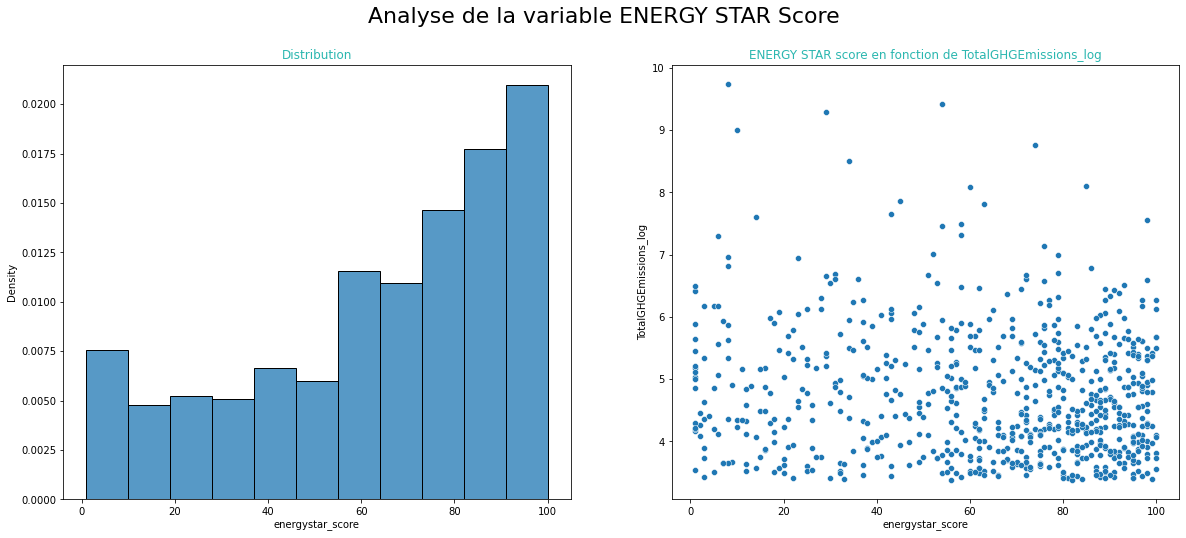

In [111]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=X, x='energystar_score', stat="density", ax=axes[0])
axes[0].set_title("Distribution", color='#2cb7b0')
sns.scatterplot(data=pd.concat([X,Y], axis=1), y=data_filter['TotalGHGEmissions_log'], x='energystar_score', ax=axes[1])
axes[1].set_title("ENERGY STAR score en fonction de TotalGHGEmissions_log", color='#2cb7b0')
plt.suptitle("Analyse de la variable ENERGY STAR Score", fontsize=22)
plt.show()

In [112]:
X_train, X_test, Y_star_train, Y_star_test = train_test_split(X, Y_star, test_size=0.25, random_state=42)

print("Entrainement: {} lignes,\nTest: {} lignes.\n".format(X_train.shape[0],
                                                            X_test.shape[0]))

Entrainement: 540 lignes,
Test: 181 lignes.



In [113]:
# transformation des variables
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [114]:
model_selectionne.fit(X_train,Y_star_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=6, max_leaf_nodes=5,
                          n_estimators=5)

In [115]:
Y_star_pred= model_selectionne.predict(X_test)
reg_met(np.array(Y_star_test), Y_star_pred)

MAE:  0.65031
MSE:  0.64078
RMSE:  0.8004900014991371
MAPE:  0.14055
R²:  0.38434


Text(0, 0.5, 'Les valeurs estimées')

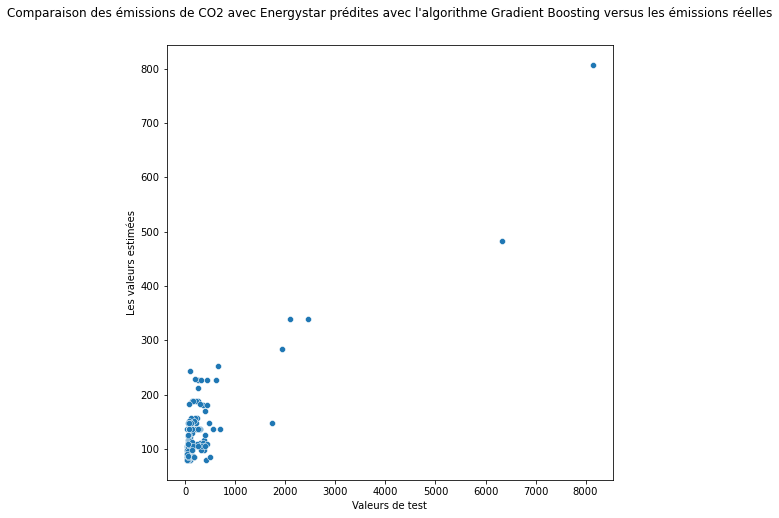

In [116]:
plt.figure(figsize=(8,8))
sns.scatterplot(np.exp(Y_star_test["TotalGHGEmissions_log"]), np.exp(Y_star_pred))
plt.title('Comparaison des émissions de CO2 avec Energystar prédites avec l\'algorithme Gradient Boosting versus les émissions réelles',y=1.05)
plt.xlabel('Valeurs de test')
plt.ylabel('Les valeurs estimées')